#### Data Augmentation to Address Overfitting - Flower Classification using CNN

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import PIL # for image processing - its successor is now pillow
import cv2 # computer vision library
import os

In [2]:
# Loading Flowers Dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='.', untar=True)

In [3]:
import pathlib
data_dir = pathlib.Path(data_dir) # window object of path
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

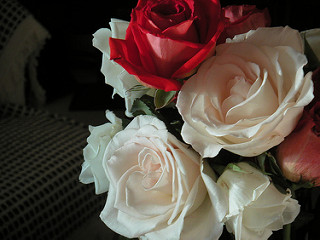

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(roses[1])

In [5]:
flowers_dir_mapping = {
    'daisy': {
        "label": 0,
        "dir": list(data_dir.glob('daisy/*')),
    },
    'dandelion': {
        "label": 1,
        "dir": list(data_dir.glob('dandelion/*')),
    },
    'roses': {
        "label": 2,
        "dir": list(data_dir.glob('roses/*')),
    },
    'sunflowers': {
        "label": 3,
        "dir": list(data_dir.glob('sunflowers/*')),
    },
    'tulips': {
        "label": 4,
        "dir": list(data_dir.glob('tulips/*')),
    }
};
for flower_name, data in flowers_dir_mapping.items():
    print(f"Flower: {flower_name}, Label: {data['label']}, Number of images: {len(data['dir'])}")

Flower: daisy, Label: 0, Number of images: 633
Flower: dandelion, Label: 1, Number of images: 898
Flower: roses, Label: 2, Number of images: 641
Flower: sunflowers, Label: 3, Number of images: 699
Flower: tulips, Label: 4, Number of images: 799


In [6]:
img = cv2.imread(str(roses[1]))
cv2.resize(img, (180, 180))

x_data = []
y_data = []
for flower_name, data in flowers_dir_mapping.items():
    for img_path in data['dir']:
        img = cv2.imread(str(img_path))
        img_resized = cv2.resize(img, (180, 180))
        x_data.append(img_resized)
        y_data.append(data['label'])

x_data = np.array(x_data)
y_data = np.array(y_data)

In [7]:
# Train Test Split and Preprocessing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

x_train_scaled = x_train.astype('float32') / 255.0
x_test_scaled = x_test.astype('float32') / 255.0

x_train_scaled.shape

(2936, 180, 180, 3)

##### Building Convolutional Neural Network - without Data Augmentation

In [ ]:
classes = 5
model = keras.Sequential([
    # cnn
    keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(180, 180, 3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    # flatten & dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(classes, activation='softmax') # 5 classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.fit(x_train_scaled, y_train, epochs=30)

Epoch 1/30
92/92 [==============================] - 4s 42ms/step - loss: 1.3026 - accuracy: 0.4700
Epoch 2/30
92/92 [==============================] - 3s 35ms/step - loss: 0.9803 - accuracy: 0.6189
Epoch 3/30
92/92 [==============================] - 3s 32ms/step - loss: 0.7943 - accuracy: 0.6969
Epoch 4/30
92/92 [==============================] - 3s 34ms/step - loss: 0.6083 - accuracy: 0.7728
Epoch 5/30
92/92 [==============================] - 3s 34ms/step - loss: 0.4394 - accuracy: 0.8474
Epoch 6/30
92/92 [==============================] - 3s 33ms/step - loss: 0.2161 - accuracy: 0.9281
Epoch 7/30
92/92 [==============================] - 3s 35ms/step - loss: 0.1185 - accuracy: 0.9659
Epoch 8/30
92/92 [==============================] - 3s 33ms/step - loss: 0.0529 - accuracy: 0.9884
Epoch 9/30
92/92 [==============================] - 3s 33ms/step - loss: 0.0354 - accuracy: 0.9918
Epoch 10/30
92/92 [==============================] - 3s 34ms/step - loss: 0.0341 - accuracy: 0.9894
Epoch 11/

In [11]:
model.evaluate(x_test_scaled, y_test)

23/23 [==============================] - 1s 22ms/step - loss: 3.2928 - accuracy: 0.6253


[3.292778253555298, 0.6253405809402466]

In [14]:
# classification report & confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
def print_report(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=flowers_dir_mapping.keys(),
                yticklabels=flowers_dir_mapping.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

              precision    recall  f1-score   support

           0       0.66      0.59      0.63       150
           1       0.67      0.76      0.71       166
           2       0.48      0.45      0.47       132
           3       0.71      0.78      0.74       129
           4       0.58      0.53      0.55       157

    accuracy                           0.63       734
   macro avg       0.62      0.62      0.62       734
weighted avg       0.62      0.63      0.62       734



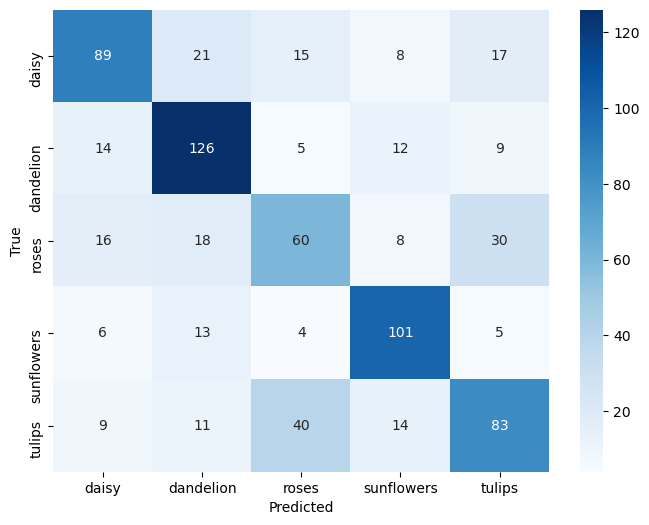

In [15]:
y_pred = model.predict(x_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
print_report(y_test, y_pred_classes)
# We can see our model is overfitting

##### Building Convolutional Neural Network - using Data Augmentation

In [84]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.RandomRotation(0.6),
    keras.layers.experimental.preprocessing.RandomContrast(0.2),
])

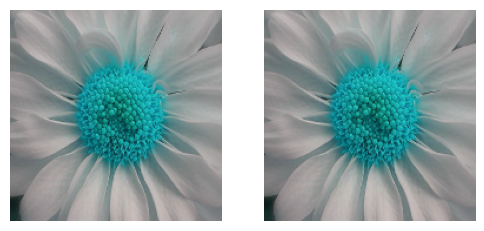

In [88]:
# Comparison between original and augmented images
plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(x_data[0])
plt.subplot(1, 2, 2)
plt.axis('off')
single_image = tf.expand_dims(x_data[0], 0)
plt.imshow(data_augmentation(single_image)[0].numpy())

In [89]:
# Building model
model_d = keras.Sequential([
    data_augmentation,
    # cnn
    keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(180, 180, 3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    # flatten & dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(classes, activation='softmax') # 5 classes
])

model_d.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [90]:
model_d.fit(x_train_scaled, y_train, epochs=30)

Epoch 1/30
92/92 [==============================] - 3s 37ms/step - loss: 1.3218 - accuracy: 0.4424
Epoch 2/30
92/92 [==============================] - 3s 37ms/step - loss: 1.1129 - accuracy: 0.5293
Epoch 3/30
92/92 [==============================] - 3s 37ms/step - loss: 1.0079 - accuracy: 0.5971
Epoch 4/30
92/92 [==============================] - 3s 37ms/step - loss: 0.9406 - accuracy: 0.6270
Epoch 5/30
92/92 [==============================] - 3s 38ms/step - loss: 0.9177 - accuracy: 0.6390
Epoch 6/30
92/92 [==============================] - 3s 38ms/step - loss: 0.8639 - accuracy: 0.6621
Epoch 7/30
92/92 [==============================] - 3s 37ms/step - loss: 0.8291 - accuracy: 0.6764
Epoch 8/30
92/92 [==============================] - 3s 37ms/step - loss: 0.7916 - accuracy: 0.6853
Epoch 9/30
92/92 [==============================] - 3s 36ms/step - loss: 0.7796 - accuracy: 0.6952
Epoch 10/30
92/92 [==============================] - 3s 36ms/step - loss: 0.7405 - accuracy: 0.7074
Epoch 11/

In [93]:
model_d.evaluate(x_test_scaled, y_test)

23/23 [==============================] - 0s 21ms/step - loss: 0.8182 - accuracy: 0.6921


[0.8182288408279419, 0.692098081111908]

              precision    recall  f1-score   support

           0       0.86      0.71      0.78       150
           1       0.74      0.73      0.73       166
           2       0.57      0.65      0.61       132
           3       0.77      0.71      0.74       129
           4       0.58      0.65      0.61       157

    accuracy                           0.69       734
   macro avg       0.70      0.69      0.70       734
weighted avg       0.71      0.69      0.70       734



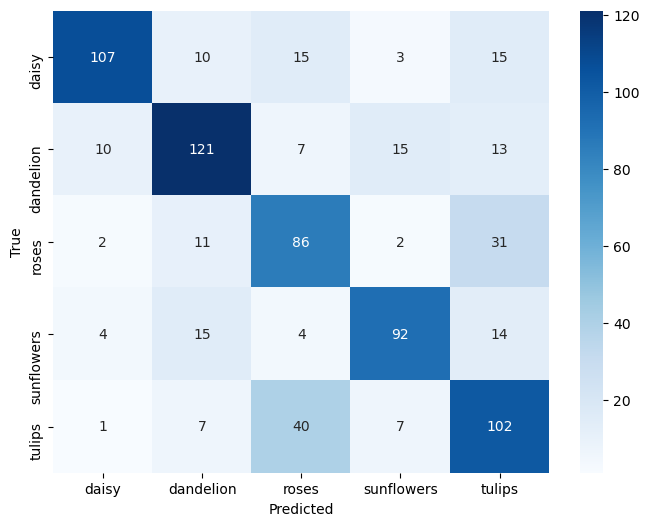

In [100]:
y_pred_d = model_d.predict(x_test_scaled)
y_pred_classes_d = np.argmax(y_pred_d, axis=1)
print_report(y_test, y_pred_classes_d)
# We can see improvement but still some overfitting

Building Model Again with Data Augmentation + Dropout Layer

In [ ]:
# Building model with dropout
model_d2 = keras.Sequential([
    data_augmentation,
    # cnn
    keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(180, 180, 3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.3),
    
    # flatten & dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(classes, activation='softmax') # 5 classes
])

model_d2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [97]:
model_d2.fit(x_train_scaled, y_train, epochs=30)

Epoch 1/30
92/92 [==============================] - 4s 40ms/step - loss: 1.3202 - accuracy: 0.4227
Epoch 2/30
92/92 [==============================] - 4s 38ms/step - loss: 1.0776 - accuracy: 0.5589
Epoch 3/30
92/92 [==============================] - 4s 39ms/step - loss: 1.0010 - accuracy: 0.6087
Epoch 4/30
92/92 [==============================] - 3s 37ms/step - loss: 0.9384 - accuracy: 0.6264
Epoch 5/30
92/92 [==============================] - 4s 39ms/step - loss: 0.8644 - accuracy: 0.6557
Epoch 6/30
92/92 [==============================] - 3s 37ms/step - loss: 0.8361 - accuracy: 0.6754
Epoch 7/30
92/92 [==============================] - 4s 38ms/step - loss: 0.7956 - accuracy: 0.6880
Epoch 8/30
92/92 [==============================] - 4s 38ms/step - loss: 0.7888 - accuracy: 0.6901
Epoch 9/30
92/92 [==============================] - 4s 38ms/step - loss: 0.7514 - accuracy: 0.6952
Epoch 10/30
92/92 [==============================] - 3s 37ms/step - loss: 0.7317 - accuracy: 0.7129
Epoch 11/

In [98]:
model_d2.evaluate(x_test_scaled, y_test)

23/23 [==============================] - 0s 15ms/step - loss: 0.7546 - accuracy: 0.7098


[0.7546072602272034, 0.7098092436790466]

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       150
           1       0.76      0.72      0.74       166
           2       0.66      0.46      0.54       132
           3       0.78      0.84      0.81       129
           4       0.59      0.73      0.65       157

    accuracy                           0.71       734
   macro avg       0.71      0.71      0.71       734
weighted avg       0.71      0.71      0.71       734



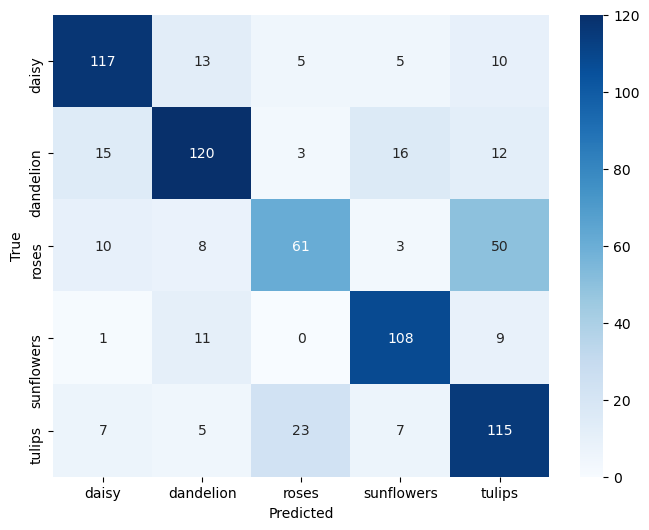

In [101]:
y_pred_d2 = model_d2.predict(x_test_scaled)
y_pred_classes_d2 = np.argmax(y_pred_d2, axis=1)
print_report(y_test, y_pred_classes_d2)
# We see further improvement and reduced overfitting